Reproduce and translate the contents of `../../jzb/data/test_load_rawdata.m` from Matlab to Python.

To run this script you'll need to install a few packages. The easy way around this (on the H2 cluster) is to do the following:
```
module load anaconda3
module load NCCL
source activate /private/home/mikerabbat/.conda/envs/fast_mri
```

That environment is based on `fair_env_latest_py3` (cloned on May 31, 2018), so it has PyTorch 0.4. It also has the ISMRMRD package (https://github.com/ismrmrd/ismrmrd-python) which can be used to load the data files, and the PyXB package (https://github.com/pabigot/pyxb) on which ISMRMRD depends.

To get this to work with our setup, I had to make a very small modification to the ISMRMRD package before installing it. In line 152 of `ismrmrd/hdf5.py`, I changed `'r+'` to `'r'`. This avoids permission errors when trying to read a data file. It is necessary since most of us only have read access to the data, and anyways, we don't need to be editing/appending to these files, so it's also safer. 

If you use the environment above (which also already has pytorch-fft installed) then you don't need to worry about 
installing either of those packages or making the changes.

In [31]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
import ismrmrd
from numpy.fft import fftshift, ifftshift, ifft

In [3]:
# Path info
dataroot = '/checkpoint02/jzb/data/nyu/raw_data/'
datadir = 'PETMR/FBAI_Knee/'
filename = 'FBAI_Knee#SPETMR#F9028#M690#D010418#T123026#CORPD_FBK_1.h5'

In [4]:
# Read the datafile and extract header information
dset = ismrmrd.Dataset(dataroot+datadir+filename, 'dataset', create_if_needed=False)
hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
enc = hdr.encoding[0]

In [5]:
# Matrix sizes
enc_Nx = enc.encodedSpace.matrixSize.x
enc_Ny = enc.encodedSpace.matrixSize.y
enc_Nz = enc.encodedSpace.matrixSize.z
print('encodedSpace.matrixSize', str([enc_Nx, enc_Ny, enc_Nz]))

rec_Nx = enc.reconSpace.matrixSize.x
rec_Ny = enc.reconSpace.matrixSize.y
rec_Nz = enc.reconSpace.matrixSize.z
print('reconSpace.matrixSize', str([rec_Nx, rec_Ny, rec_Nz]))


# Here's how to get the field of view parameters in case they're needed in the future
# enc_FOVx = enc.encodedSpace.fieldOfView_mm.x
# enc_FOVy = enc.encodedSpace.fieldOfView_mm.y
# enc_FOVz = enc.encodedSpace.fieldOfView_mm.z

# rec_FOVx = enc.reconSpace.fieldOfView_mm.x
# rec_FOVy = enc.reconSpace.fieldOfView_mm.y
# rec_FOVz = enc.reconSpace.fieldOfView_mm.z


encodedSpace.matrixSize [640, 368, 1]
reconSpace.matrixSize [320, 320, 1]


In [6]:
# Other parameters
if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1
print('nslices', nslices)
    
if hdr.acquisitionSystemInformation.receiverChannels != None:
    ncoils = hdr.acquisitionSystemInformation.receiverChannels
else:
    ncoils = 1
print('ncoils', ncoils)
    
if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1
print('nreps', nreps)
    
if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1
print('ncontrasts', ncontrasts)
    
    

nslices 40
ncoils 15
nreps 1
ncontrasts 1


In [7]:
# Ignore noise scans
firstscan = 0
while True:
    acq = dset.read_acquisition(firstscan)
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        firstscan += 1
    else:
        break


In [8]:
# Load data
nacq = dset.number_of_acquisitions()
kdata = np.zeros((nreps, ncontrasts, nslices, enc_Nx, enc_Ny, enc_Nz, ncoils), dtype=np.complex64)
for scan in range(firstscan, nacq):
    acq = dset.read_acquisition(scan)
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    sl = acq.idx.slice
    ky = acq.idx.kspace_encode_step_1
    kz = acq.idx.kspace_encode_step_2
    kdata[rep, contrast, sl, :, ky, kz, :] = acq.data.T


In [9]:
# Reconstruct
use_sign = True
recon_images = []
recon_images_complex = []
recon_images_complex_signed = []

for rep in range(nreps):
    for contrast in range(ncontrasts):
        for sl in range(nslices):
            # Grab the slice of data for this image
            K = kdata[rep, contrast, sl, :, :, :, :]
            # Reconstruct in x
            K = fftshift(ifft(fftshift(K, axes=0), axis=0), axes=0)
            # Chop if needed
            if enc_Nx == rec_Nx:
                im = K
            else:
                ind1 = (enc_Nx - rec_Nx) // 2
                ind2 = (enc_Nx - rec_Nx) // 2 + rec_Nx
                im = K[ind1:ind2,:,:,:]
            # Reconstruct in y then z
            im = fftshift(ifft(fftshift(im, axes=1), axis=1), axes=1)
            if im.shape[2] > 1:
                im = fftshift(ifft(fftshift(im, axes=2), axis=2), axes=2)
            # Combine SOS across coils
            im1 = np.sqrt(np.sum(np.abs(im) ** 2, axis=3))
            # Append to the list
            recon_images.append(im1)
            
            # my approximation
            data = im
            real = data.real
            real_sign = np.sign(np.sum(real, axis=3))
            real = np.sqrt(np.sum(real ** 2, axis=3))
            imag = data.imag
            imag_sign = np.sign(np.sum(imag, axis=3))
            imag = np.sqrt(np.sum(imag ** 2, axis=3))
            recon_images_complex.append(real + 1j * imag)

            imag = imag * imag_sign
            real = real * real_sign
            im2 = (real + 1j * imag)
            recon_images_complex_signed.append(im2)

            


(-0.5, 367.5, 319.5, -0.5)

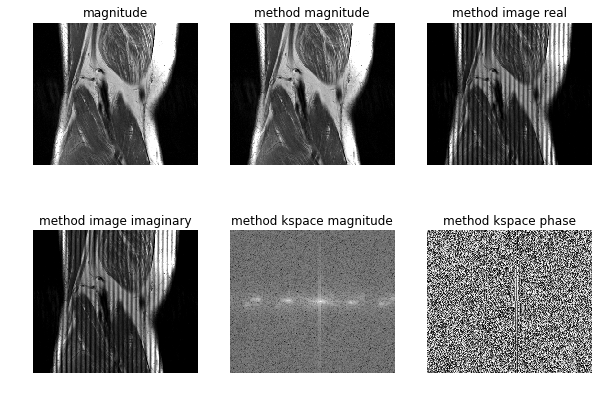

In [38]:
# Display the first image
sl = 0
plt.figure(figsize=(10,7))
plt.subplot(231)
plt.axis('off')
plt.imshow(np.fliplr(np.flipud(recon_images[39][:,:,0])), vmin=3.94e-08, vmax=1e-06, cmap='gray')
plt.title('magnitude')
plt.subplot(232)
plt.imshow(np.fliplr(np.flipud(np.abs(recon_images_complex[39][:,:,0]))), vmin=3.94e-08, vmax=1e-06, cmap='gray')
plt.title('method magnitude')
plt.axis('off')

img = recon_images_complex_signed[39][:,:,0]


plt.subplot(233)
plt.imshow(np.fliplr(np.flipud(np.abs(img.real))), vmin=3.94e-08, vmax=1e-06, cmap='gray')
plt.title('method image real')
plt.axis('off')
plt.subplot(234)
plt.imshow(np.fliplr(np.flipud(np.abs(img.imag))), vmin=3.94e-08, vmax=1e-06, cmap='gray')
plt.title('method image imaginary')
plt.axis('off')
kspace = np.fft.fftshift(np.fft.fft2(img))

plt.subplot(235)
plt.imshow(np.fliplr(np.flipud(np.log(np.abs(kspace)))), cmap='gray')
plt.title('method kspace magnitude')
plt.axis('off')
plt.subplot(236)
plt.imshow(np.fliplr(np.flipud((np.angle(kspace)))), cmap='gray')
plt.title('method kspace phase')
plt.axis('off')

In [11]:
recon_volume = np.stack(recon_images_complex)
mean = recon_volume.mean()
std = recon_volume.std()

In [29]:
img.shape

(320, 368)

In [ ]:
img = recon_volume[38][:,:,0]
img = (img - mean) / std

# img = recon_volume[38]
print(img.min(), img.max())
img = np.clip(img,-3,3)
print(img.min(), img.max())
img = np.abs(img)
img  = (img - img.min()) / (img.max() - img.min())

plt.figure()
plt.imshow(np.fliplr(np.flipud(img)), vmin=0, vmax=1, cmap='gray')

In [ ]:
img = np.abs(recon_volume[38])[:,:,0]
img = (img - np.abs(mean)) / np.abs(std)

# img = recon_volume[38]
print(img.min(), img.max())
img = np.clip(img,-3,3)
print(img.min(), img.max())
img  = (img - img.min()) / (img.max() - img.min())

plt.figure()
plt.imshow(np.fliplr(np.flipud(img)), cmap='gray')

In [ ]:
# Display the first image
sl = 0
plt.figure()
plt.imshow(np.fliplr(np.flipud(np.abs(recon_images_complex[39][:,:,0]))), vmin=3.94e-08, vmax=1e-06, cmap='gray')

In [ ]:
plt.figure()
plt.imshow(np.fliplr(np.flipud(np.abs(recon_images_complex[39][:,:,0]))), vmin=3.94e-08, vmax=1e-06, cmap='gray')

In [ ]:
# Display the first image
sl = 0
plt.figure()
plt.imshow(np.fliplr(np.flipud(np.abs(recon_images_complex[39][:,:,0]))), vmin=3.94e-08, vmax=1e-06, cmap='gray')

In [ ]:
a = 0.5  + 1j * 2

In [25]:
np.ones(10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
np.abs(a)

In [ ]:
np.linalg.norm(a)

In [16]:
a = plt.bar(0,10)

<IPython.core.display.Javascript object>


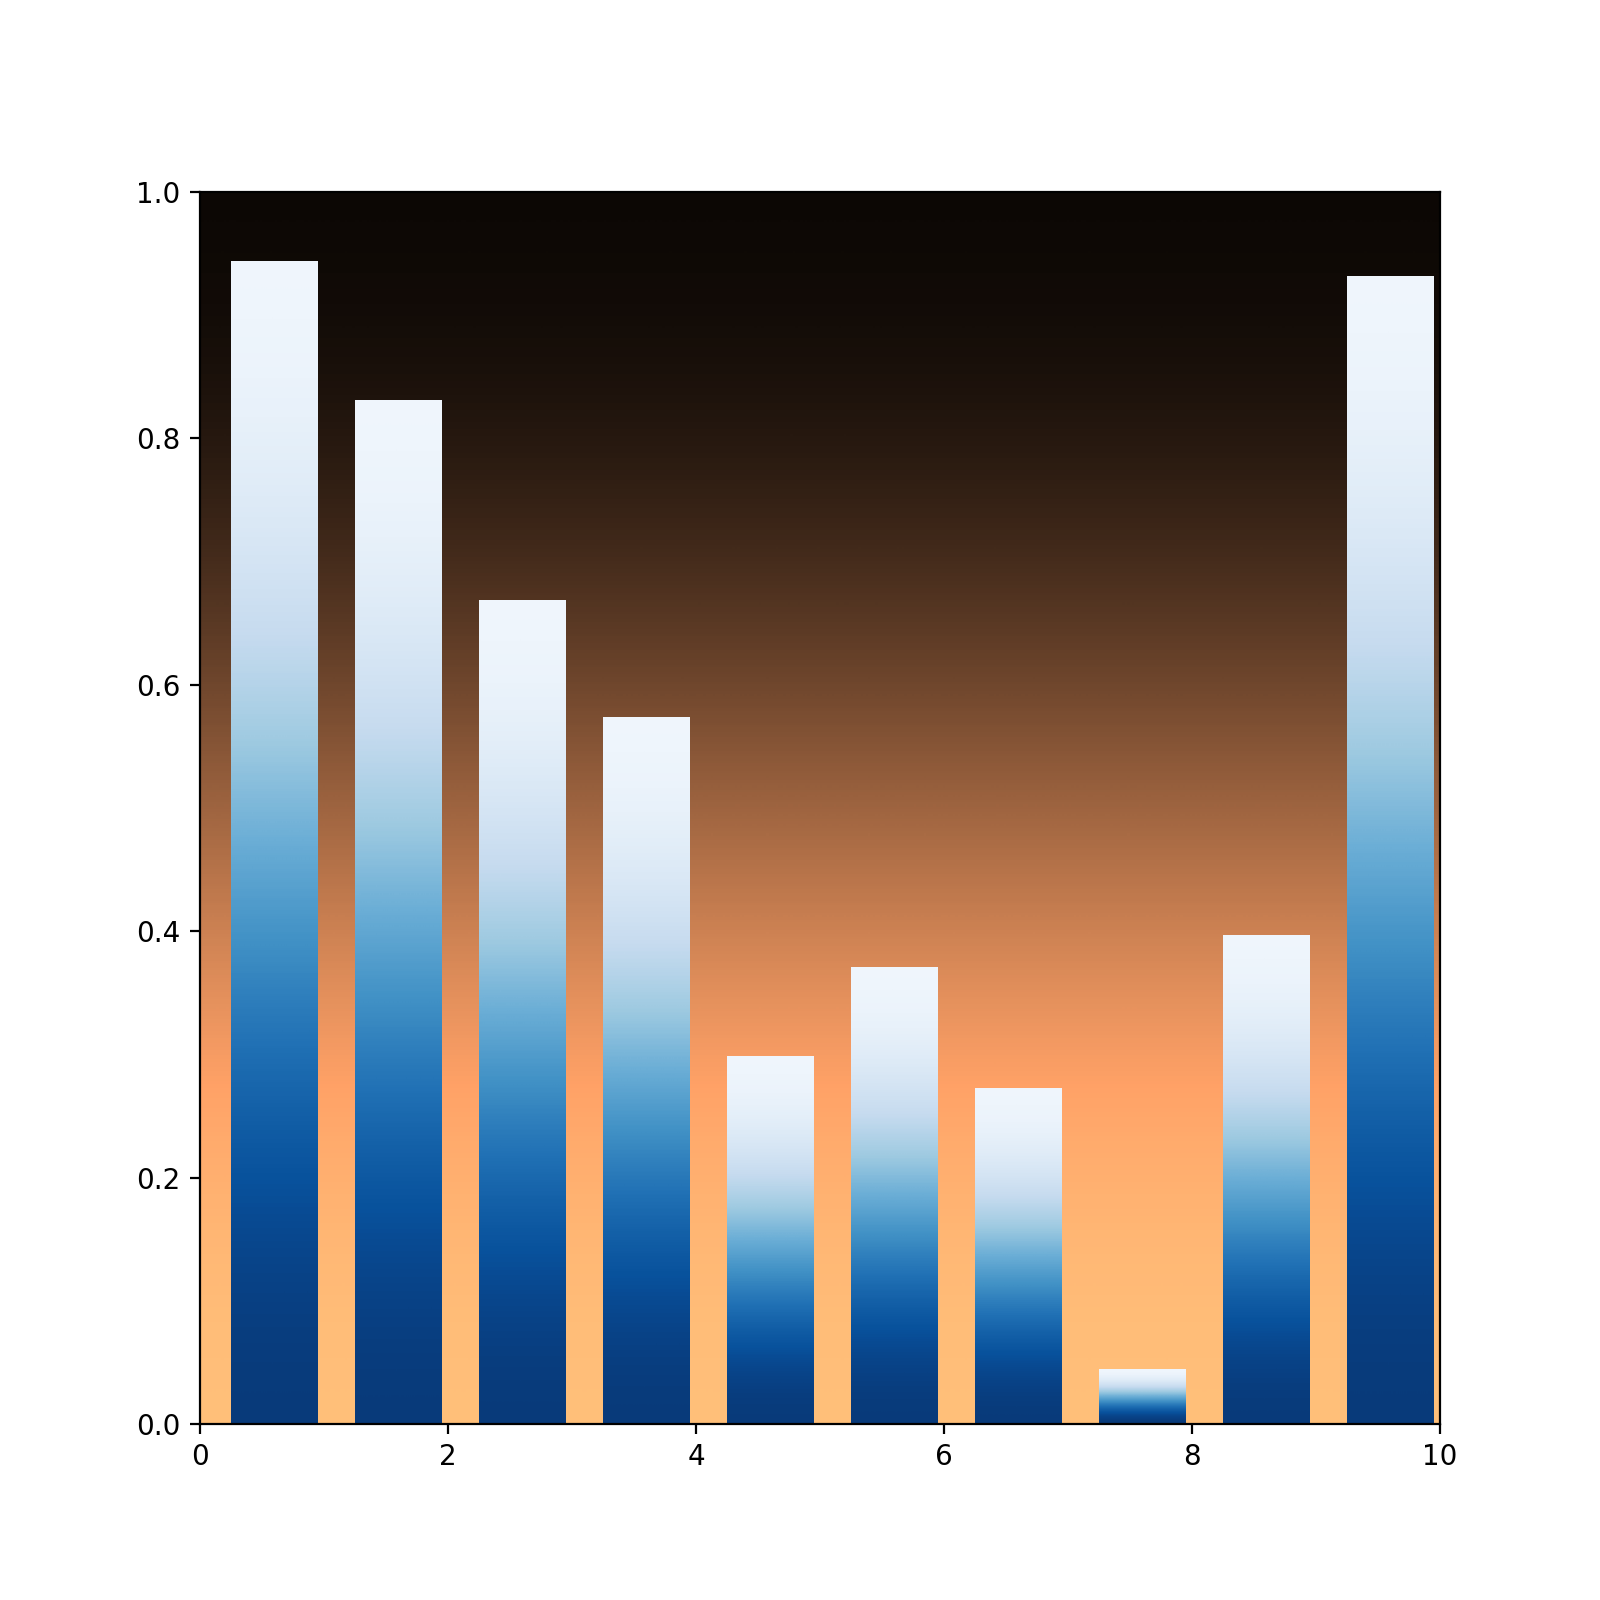

In [20]:
xmin, xmax = xlim = 0, 10
ymin, ymax = ylim = 0, 1
def gbar(ax, x, y, width=0.5, bottom=0):
    X = [[.6, .6], [.7, .7]]
    for left, top in zip(x, y):
        right = left + width
        ax.imshow(X, interpolation='bicubic', cmap=plt.cm.Blues,
                  extent=(left, right, bottom, top), alpha=1)

fig, ax = plt.subplots()
ax.set(xlim=xlim, ylim=ylim, autoscale_on=False)

X = [[.6, .6], [.7, .7]]
ax.imshow(X, interpolation='bicubic', cmap=plt.cm.copper,
          extent=(xmin, xmax, ymin, ymax), alpha=1)

N = 10
x = np.arange(N) + 0.25
y = np.random.rand(N)
gbar(ax, x, y, width=0.7)
ax.set_aspect('auto')
plt.show()

<IPython.core.display.Javascript object>


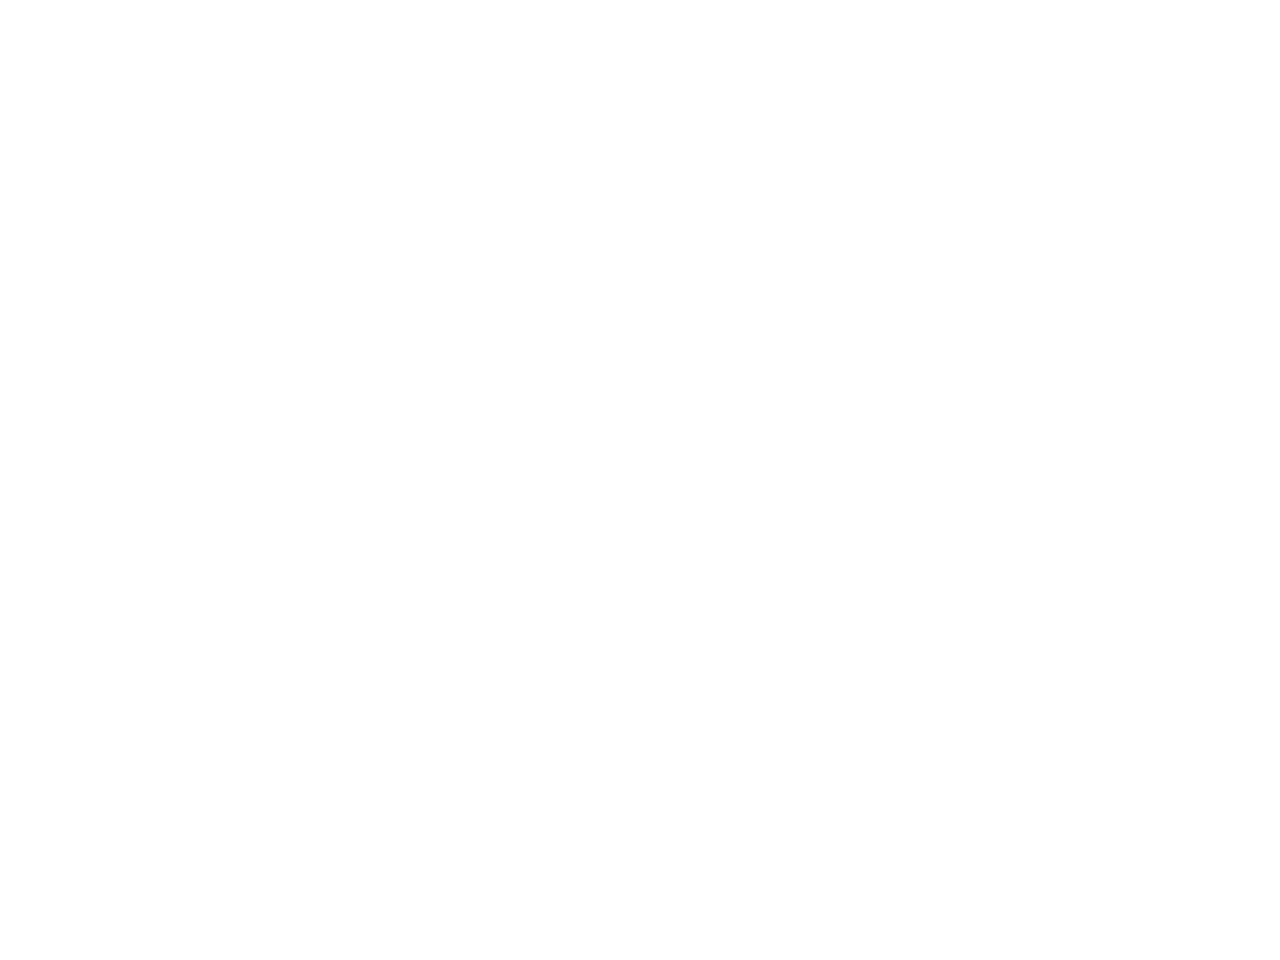

<IPython.core.display.Javascript object>


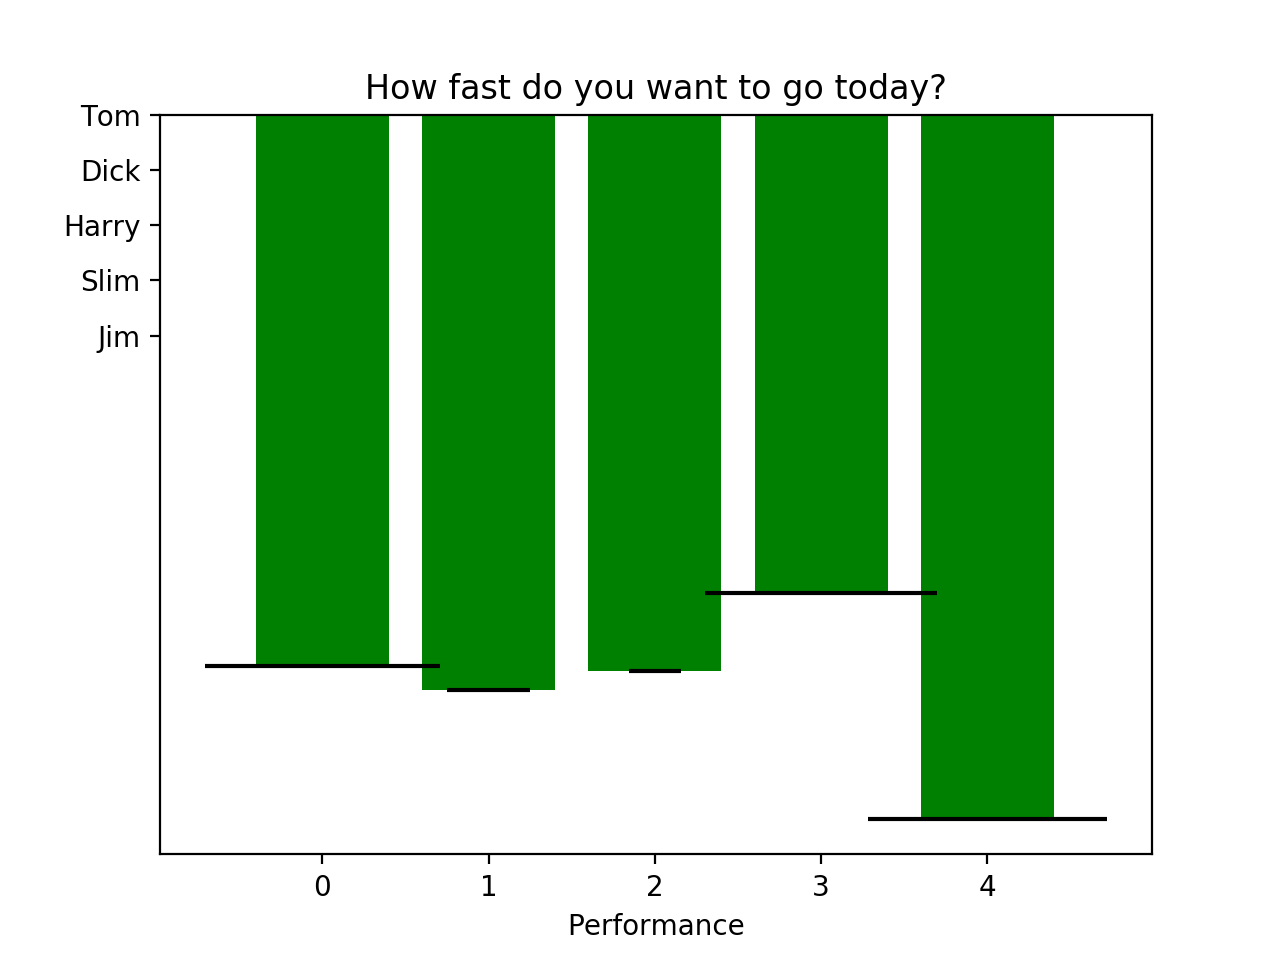

<IPython.core.display.Javascript object>


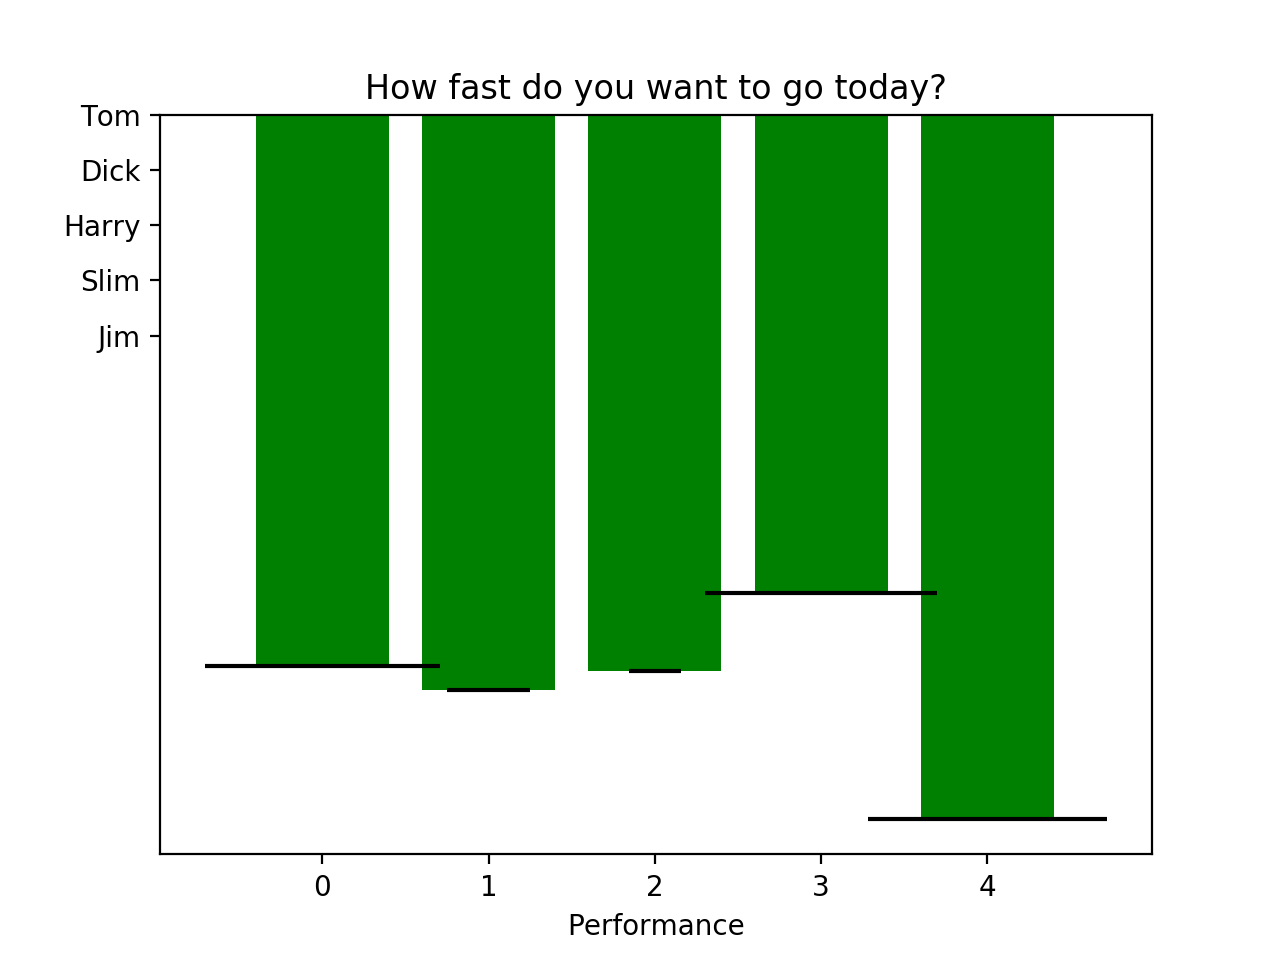

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = ('Tom', 'Dick', 'Harry', 'Slim', 'Jim')
y_pos = np.arange(len(people))
performance = 3 + 10 * np.random.rand(len(people))
error = np.random.rand(len(people))

ax.bar(y_pos, performance, xerr=error, align='center',
        color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Performance')
ax.set_title('How fast do you want to go today?')
plt.show()